# Connecting to Google Drive and Dependencies Installation

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
!pip install kaggle
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 4.1 MB/s eta 0:00:00


In [ ]:
from google.colab import files

# Upload the Kaggle API key
# You should create Kaggle account: Settings -> Generate API token -> download kaggle.json file and upload in this cell
uploaded = files.upload()

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nguyentrongdai/vietnamese-currency
!unzip -q vietnamese-currency.zip -d vietnamese-currency

In [ ]:
from ultralytics import YOLO
import cv2
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image, clear_output

# Pre-processing Dataset

In [ ]:
class PreprocessDataset():
    def __init__(self, dataset_path, output_path, train_split, valid_test_split):
        self.dataset_path = dataset_path
        self.output_path = output_path
        self.train_split = train_split
        self.valid_test_split = valid_test_split

        if float(self.train_split + 2 * self.valid_test_split) != float(1):
          raise ValueError("Sum of Train - Valid - Test split must be 1.")

        if not os.path.exists(self.output_path):
            os.mkdir(self.output_path)
            os.mkdir(os.path.join(self.output_path, 'train'))
            os.mkdir(os.path.join(self.output_path, 'val'))
            os.mkdir(os.path.join(self.output_path, 'test'))

    def read_image(self, folder_path, image_path, directory_type):
        img = cv2.imread(os.path.join(folder_path, image_path))
        cv2.imwrite(os.path.join(self.output_path, directory_type, image_path), img)

    def convertPath(self):
        folders = sorted([folder for folder in os.listdir(self.dataset_path) if not folder.endswith('data')])
        for folder in folders:
            folder_path = os.path.join(self.dataset_path, folder)
            images = os.listdir(folder_path)
            train_size = int(self.train_split * len(images))
            valid_test_size = int(self.valid_test_split * len(images))
            train_set = images[:train_size]
            valid_set = images[train_size:(train_size + valid_test_size)]
            test_set = images[(train_size + valid_test_size):]

            if not os.path.exists(os.path.join(self.output_path, 'train', folder)):
                os.mkdir(os.path.join(self.output_path, 'train', folder))
            if not os.path.exists(os.path.join(self.output_path, 'val', folder)):
                os.mkdir(os.path.join(self.output_path, 'val', folder))
            if not os.path.exists(os.path.join(self.output_path, 'test', folder)):
                os.mkdir(os.path.join(self.output_path, 'test', folder))

            with tqdm(total=len(train_set), desc=f'Training set ({folder} vnd)') as pbar:
                for train in train_set:
                    self.read_image(folder_path, train, f'train/{folder}')
                    pbar.update(1)
            with tqdm(total=len(valid_set), desc=f'Validation set ({folder} vnd)') as pbar:
                for valid in valid_set:
                    self.read_image(folder_path, valid, f'val/{folder}')
                    pbar.update(1)
            with tqdm(total=len(test_set), desc=f'Test set ({folder} vnd)') as pbar:
                for valid in test_set:
                    self.read_image(folder_path, valid, f'test/{folder}')
                    pbar.update(1)
            print('\n')


vietnamese_currency = PreprocessDataset(dataset_path='/content/vietnamese-currency',
                                        output_path='/content/VietNamese_Currency',
                                        train_split=0.8,
                                        valid_test_split=0.1)

vietnamese_currency.convertPath()

Test set (000000 vnd): 100%|██████████| 25/25 [00:00<00:00, 107.26it/s]


Test set (000200 vnd): 100%|██████████| 25/25 [00:00<00:00, 108.33it/s]


Test set (000500 vnd): 100%|██████████| 25/25 [00:00<00:00, 98.72it/s]


Test set (001000 vnd): 100%|██████████| 25/25 [00:00<00:00, 144.34it/s]


Test set (002000 vnd): 100%|██████████| 25/25 [00:00<00:00, 98.51it/s] 


Test set (005000 vnd): 100%|██████████| 16/16 [00:00<00:00, 104.19it/s]


Test set (010000 vnd): 100%|██████████| 25/25 [00:00<00:00, 131.54it/s]


Test set (020000 vnd): 100%|██████████| 16/16 [00:00<00:00, 118.27it/s]


Test set (050000 vnd): 100%|██████████| 16/16 [00:00<00:00, 114.60it/s]


Test set (100000 vnd): 100%|██████████| 25/25 [00:00<00:00, 107.34it/s]


Test set (200000 vnd): 100%|██████████| 25/25 [00:00<00:00, 109.53it/s]


Test set (500000 vnd): 100%|██████████| 25/25 [00:00<00:00, 108.99it/s]

# Installing and configuring pre-trained YOLOv8 model

In [ ]:
model = YOLO("yolov8n-cls.pt")

In [ ]:
# make sure that you enabled `resume` and `save_dir` to prevent the unexpected interruption.
results = model.train(data=vietnamese_currency.output_path,
                      epochs=100,
                      patience=10,
                      batch=8,
                      save=True,
                      dropout=0.7,
                      degrees=40,
                      translate=0.3,
                      shear=0.2,
                      perspective=0.0001,
                      flipud=0.5,
                      resume=True,
                      save_dir='/drive/MyDrive/VN_Currency/runs/classify/train')

Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/VietNamese_Currency, epochs=100, time=None, patience=10, batch=8, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.7, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

train: Scanning /content/VietNamese_Currency/train... 2169 images, 0 corrupt: 100%|██████████| 2169/2169 [00:00<?, ?it/s]
val: Scanning /content/VietNamese_Currency/val... 270 images, 0 corrupt: 100%|██████████| 270/270 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100      1.06G        2.5          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.43it/s]

                   all      0.467      0.819



      Epoch    GPU_mem       loss  Instances       Size


      2/100     0.403G      1.901          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.67it/s]

                   all      0.793      0.978



      Epoch    GPU_mem       loss  Instances       Size


      3/100     0.403G      1.116          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:01<00:00, 14.98it/s]

                   all        0.9      0.996



      Epoch    GPU_mem       loss  Instances       Size


      4/100     0.403G     0.7536          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 20.70it/s]

                   all      0.944      0.996



      Epoch    GPU_mem       loss  Instances       Size


      5/100     0.403G     0.5662          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 24.10it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


      6/100     0.403G     0.4964          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:01<00:00, 12.37it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


      7/100     0.403G     0.4366          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.59it/s]

                   all      0.974      0.996



      Epoch    GPU_mem       loss  Instances       Size


      8/100     0.403G     0.4141          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.46it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.56it/s]

                   all       0.97      0.996



      Epoch    GPU_mem       loss  Instances       Size


      9/100     0.403G     0.3558          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.49it/s]

                   all      0.974      0.996



      Epoch    GPU_mem       loss  Instances       Size


     10/100     0.386G     0.3316          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 23.11it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


     11/100     0.377G     0.3025          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 20.51it/s]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


     12/100     0.377G      0.272          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.40it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     13/100     0.377G     0.2966          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.90it/s]

                   all      0.981          1



      Epoch    GPU_mem       loss  Instances       Size


     14/100     0.377G      0.235          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:01<00:00, 12.54it/s]

                   all      0.981      0.996



      Epoch    GPU_mem       loss  Instances       Size


     15/100     0.377G     0.2493          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.04it/s]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


     16/100     0.377G      0.242          1        224: 100%|██████████| 272/272 [00:18<00:00, 14.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.25it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     17/100     0.377G     0.2051          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:01<00:00, 16.78it/s]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


     18/100     0.377G     0.2048          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.07it/s]

                   all      0.981          1



      Epoch    GPU_mem       loss  Instances       Size


     19/100     0.377G     0.1834          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.27it/s]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100     0.377G     0.1959          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.75it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     21/100     0.377G     0.1865          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:01<00:00, 14.02it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     22/100     0.377G     0.1799          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.74it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     23/100     0.377G     0.1631          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.14it/s]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


     24/100     0.377G     0.1465          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 19.86it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     25/100     0.377G     0.1688          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 24.05it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     26/100     0.377G     0.1582          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.02it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     27/100     0.377G      0.152          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 20.29it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     28/100     0.377G     0.1393          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:01<00:00, 15.46it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     29/100     0.377G     0.1507          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.27it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     30/100     0.377G     0.1377          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.87it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     31/100     0.377G     0.1443          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:01<00:00, 12.93it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     32/100     0.377G     0.1097          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 23.13it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     33/100     0.375G     0.1263          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.34it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     34/100     0.377G     0.1285          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 24.06it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     35/100     0.375G     0.1226          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.45it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     36/100     0.377G     0.1328          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.91it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     37/100     0.377G     0.1419          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 20.10it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     38/100     0.377G     0.1035          1        224: 100%|██████████| 272/272 [00:18<00:00, 14.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.42it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     39/100     0.377G     0.1269          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.10it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     40/100     0.375G     0.1041          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.15it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     41/100     0.377G    0.09346          1        224: 100%|██████████| 272/272 [00:21<00:00, 12.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 24.51it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     42/100     0.377G     0.1214          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 20.40it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     43/100     0.375G    0.09128          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 17.21it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     44/100     0.377G       0.11          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.15it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 23.81it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     45/100     0.377G    0.08698          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 23.04it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     46/100     0.377G    0.07601          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.18it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     47/100     0.377G    0.09582          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:01<00:00, 16.46it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     48/100     0.377G    0.09948          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.21it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     49/100     0.377G    0.08646          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.75it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     50/100     0.377G    0.09539          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:01<00:00, 13.73it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     51/100     0.375G     0.1033          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 20.77it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     52/100     0.377G    0.09538          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.99it/s]

                   all      0.996      0.996



      Epoch    GPU_mem       loss  Instances       Size


     53/100     0.375G    0.07711          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:01<00:00, 13.82it/s]

                   all      0.989      0.996



      Epoch    GPU_mem       loss  Instances       Size


     54/100     0.377G    0.07737          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.42it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     55/100     0.377G    0.07697          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.93it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     56/100     0.377G    0.08915          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 19.85it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     57/100     0.377G      0.086          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.38it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     58/100     0.377G    0.09225          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 20.66it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     59/100     0.377G    0.07961          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 20.53it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     60/100     0.377G    0.06158          1        224: 100%|██████████| 272/272 [00:18<00:00, 14.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.05it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     61/100     0.375G    0.05978          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.14it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.46it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     62/100     0.377G    0.07202          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.42it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     63/100     0.375G    0.07803          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:01<00:00, 13.83it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


     64/100     0.377G    0.05061          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.95it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     65/100     0.375G    0.06061          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.78it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     66/100     0.375G    0.06892          1        224: 100%|██████████| 272/272 [00:22<00:00, 12.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:01<00:00, 13.49it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     67/100     0.377G    0.05864          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 20.45it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     68/100     0.375G     0.0758          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.37it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     69/100     0.377G    0.08032          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:01<00:00, 15.97it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     70/100     0.377G    0.05744          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.25it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     71/100     0.377G    0.06461          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.25it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


     72/100     0.377G    0.05316          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:01<00:00, 15.95it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     73/100     0.377G    0.05933          1        224: 100%|██████████| 272/272 [00:18<00:00, 15.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.26it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     74/100     0.375G    0.05063          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.80it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     75/100     0.377G    0.05587          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 19.94it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     76/100     0.377G    0.06739          1        224: 100%|██████████| 272/272 [00:18<00:00, 14.53it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.96it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     77/100     0.377G    0.03758          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 22.42it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     78/100     0.377G    0.06185          1        224: 100%|██████████| 272/272 [00:17<00:00, 15.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 19.77it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     79/100     0.377G    0.05636          1        224: 100%|██████████| 272/272 [00:18<00:00, 14.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 20.66it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     80/100     0.375G    0.04543          1        224: 100%|██████████| 272/272 [00:16<00:00, 16.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 24.38it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     81/100     0.377G    0.05641          1        224: 100%|██████████| 272/272 [00:17<00:00, 16.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:00<00:00, 21.21it/s]

                   all      0.996          1


Stopping training early as no improvement observed in last 10 epochs. Best results observed at epoch 71, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

81 epochs completed in 0.421 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.0MB

Validating runs/classify/train/weights/best.pt...
Ultralytics YOLOv8.1.9 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1450252 parameters, 0 gradients, 3.3 GFLOPs
train: /content/VietNamese_Currency/train... found 2169 images in 12 classes ✅ 
val: /content/VietNamese_Currency/val... found 270 images in 12 classes ✅ 
test: /content/VietNamese_Currency/test... found 273 images in 12 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 17/17 [00:01<00:00, 10.40it/s]


                   all          1          1
Speed: 0.5ms preprocess, 2.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train
Results saved to runs/classify/train


# Testing performance and evaluation

In [ ]:
# print(results[0].names) # to make sure the classes' order
classes = {0: 'Not Found Currency',
           1: '200 vnd',
           2: '500 vnd',
           3: '1.000 vnd',
           4: '2.000 vnd',
           5: '5.000 vnd',
           6: '10.000 vnd',
           7: '20.000 vnd',
           8: '50.000 vnd',
           9: '100.000 vnd',
           10: '200.000 vnd',
           11: '500.000 vnd'}

directory_path = '/content/VietNamese_Currency/test'

currency = sorted([cr for cr in os.listdir(directory_path)])
image_path = []
true_label = []
true_class = 0

for vnd in currency:
  for image in os.listdir(os.path.join(directory_path, vnd)):
    image_path.append(os.path.join(directory_path, vnd, image))
    true_label.append(classes[true_class])
  true_class += 1

In [ ]:
predict_model = YOLO('/content/runs/classify/train/weights/best.pt')
results = model(image_path, save=True, save_conf=True)


0: 224x224 000000 1.00, 200000 0.00, 001000 0.00, 100000 0.00, 500000 0.00, 1: 224x224 000000 1.00, 100000 0.00, 050000 0.00, 005000 0.00, 200000 0.00, 2: 224x224 000000 1.00, 000200 0.00, 005000 0.00, 001000 0.00, 000500 0.00, 3: 224x224 000000 1.00, 100000 0.00, 001000 0.00, 200000 0.00, 010000 0.00, 4: 224x224 000000 1.00, 005000 0.00, 050000 0.00, 000200 0.00, 002000 0.00, 5: 224x224 000000 1.00, 000200 0.00, 005000 0.00, 000500 0.00, 100000 0.00, 6: 224x224 000000 1.00, 100000 0.00, 050000 0.00, 005000 0.00, 200000 0.00, 7: 224x224 000000 1.00, 100000 0.00, 001000 0.00, 005000 0.00, 200000 0.00, 8: 224x224 000000 1.00, 000500 0.00, 002000 0.00, 010000 0.00, 200000 0.00, 9: 224x224 000000 1.00, 001000 0.00, 100000 0.00, 200000 0.00, 002000 0.00, 10: 224x224 000000 1.00, 000200 0.00, 005000 0.00, 000500 0.00, 001000 0.00, 11: 224x224 000000 1.00, 000200 0.00, 005000 0.00, 050000 0.00, 100000 0.00, 12: 224x224 000000 1.00, 200000 0.00, 001000 0.00, 100000 0.00, 010000 0.00, 13: 224x

In [ ]:
accuracy = 0

for image in range(len(results)):
  probs = results[image].probs.top1

  # print(f'predict class: {classes[probs]}')
  # print(f'true label: {true_label[image]}')

  if classes[probs] == true_label[image]:
    accuracy += 1
  else: print(f'index {image}: confuse {true_label[image]} to {classes[probs]}')

print(f'Accuracy: {round(accuracy * 100 / len(results), 2)}%')

Accuracy: 100.0%


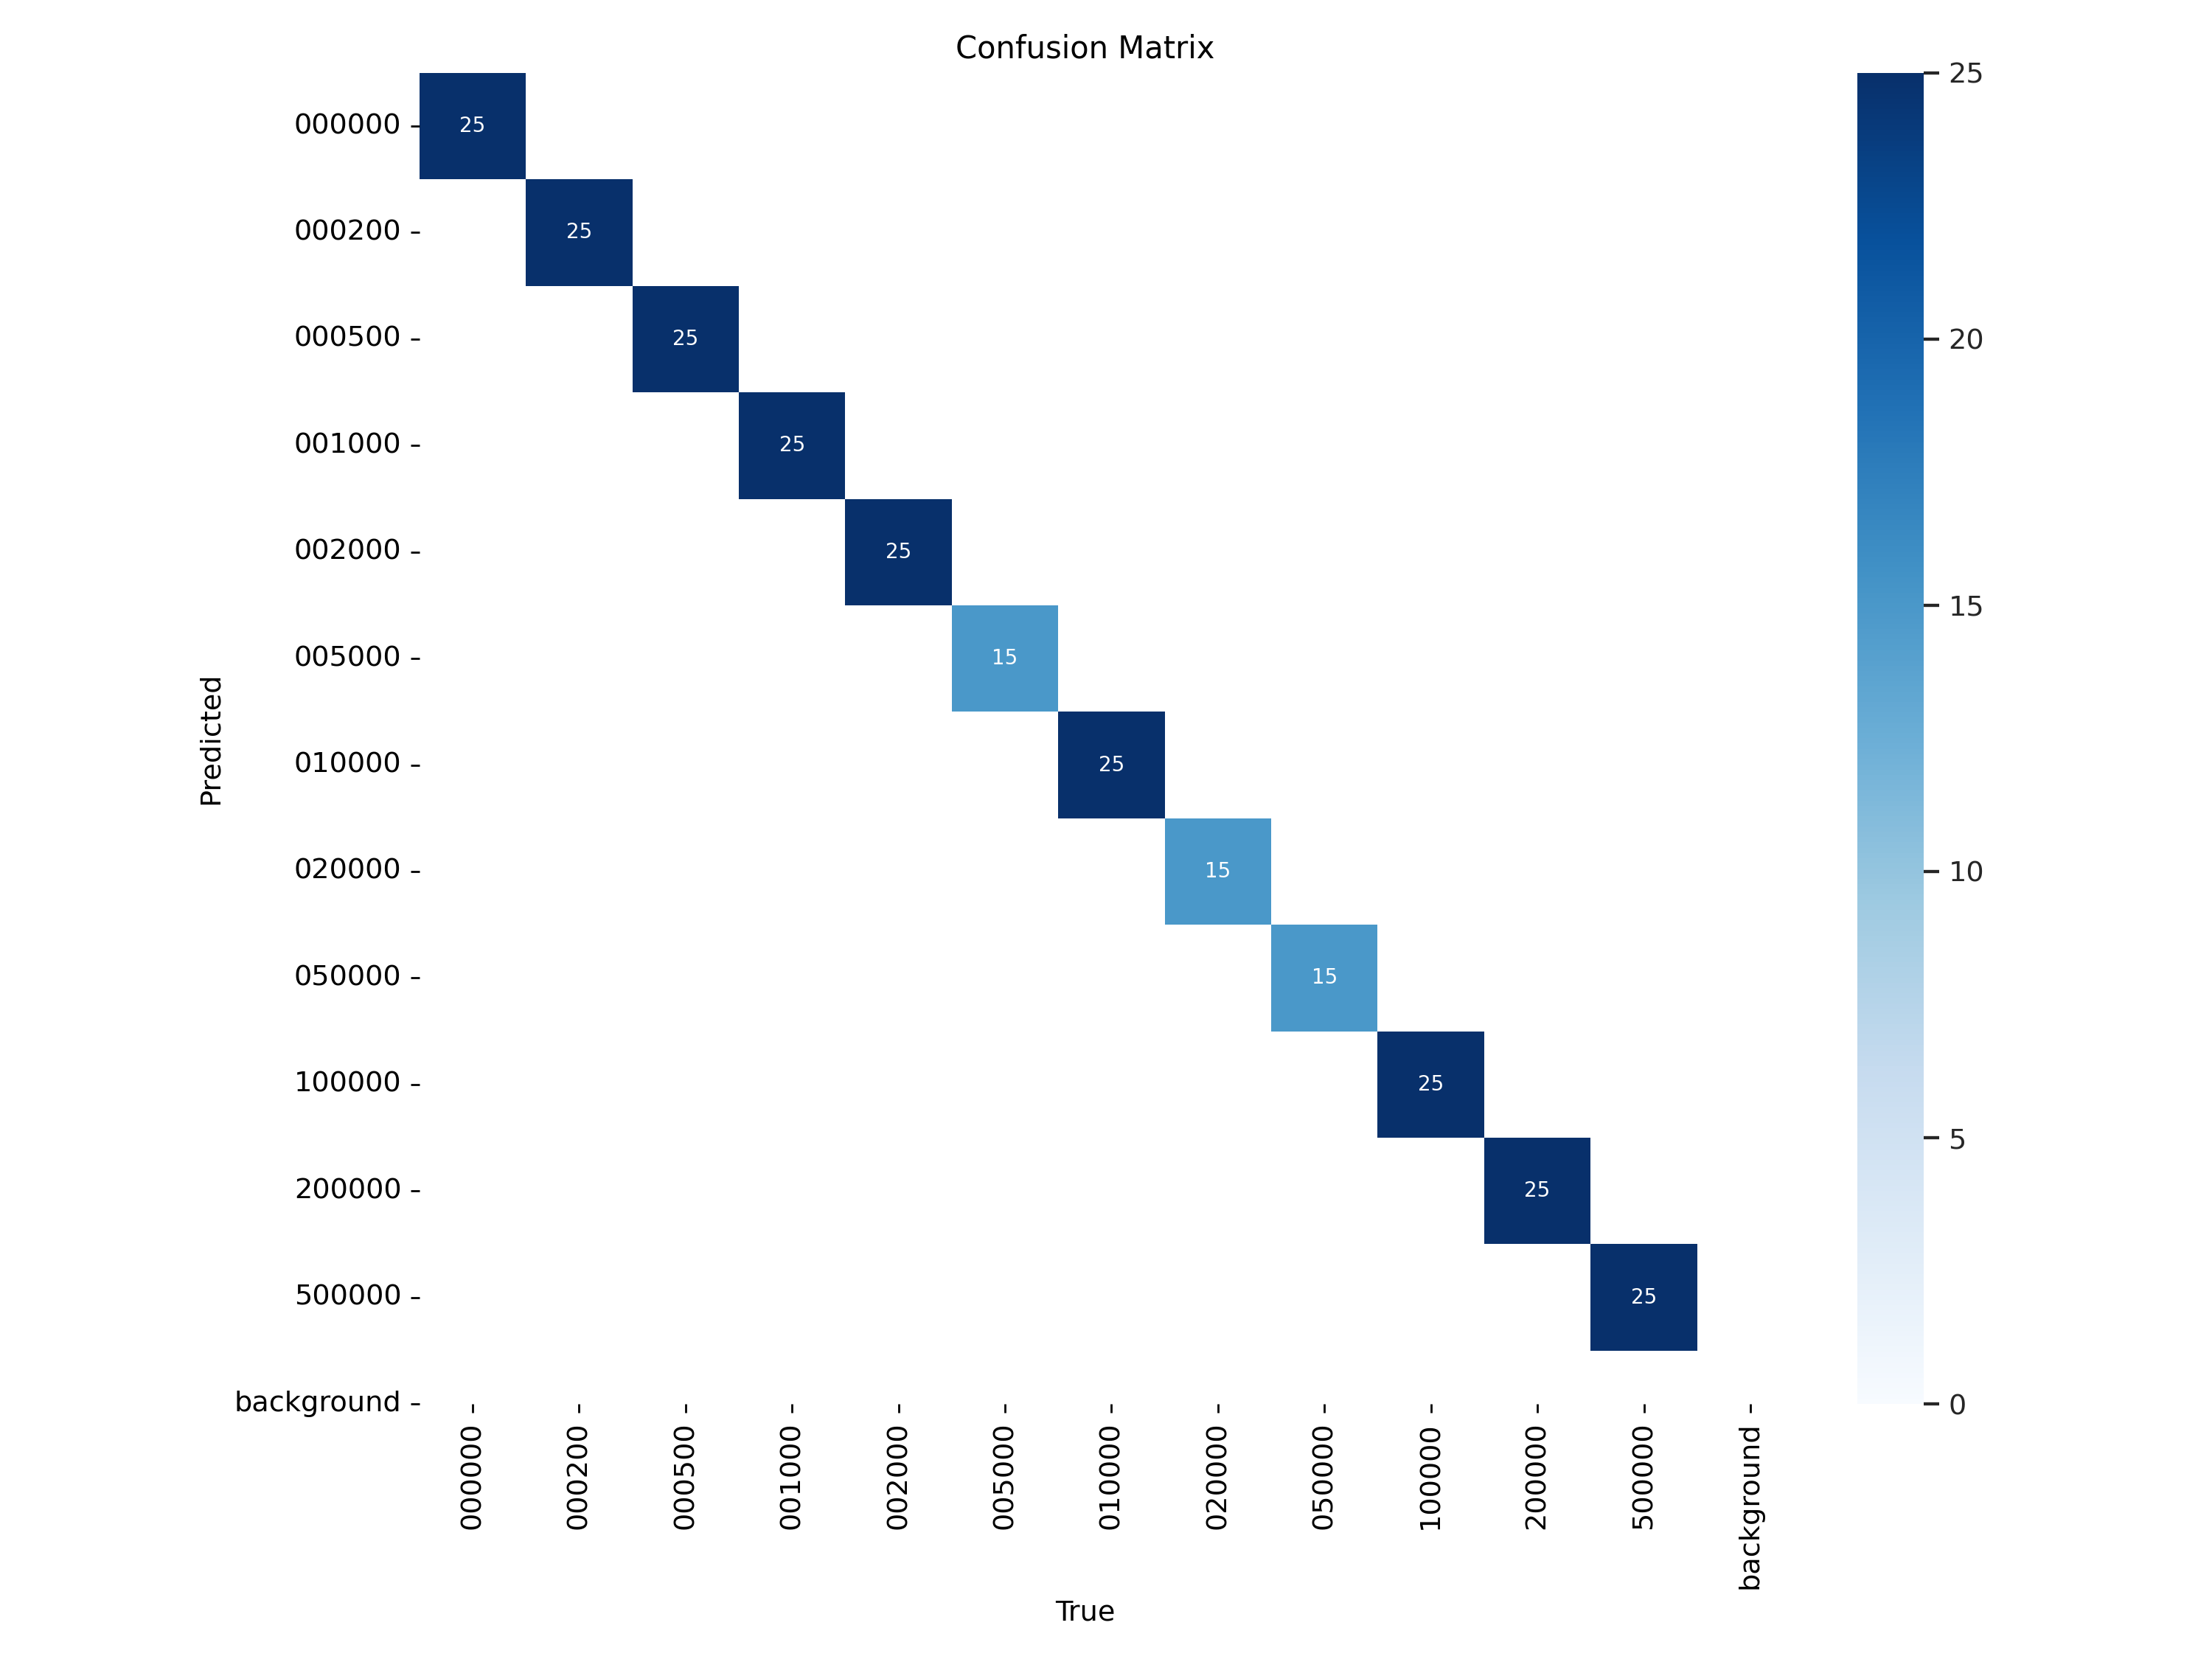

In [ ]:
Image(filename='/content/runs/classify/train/confusion_matrix.png')

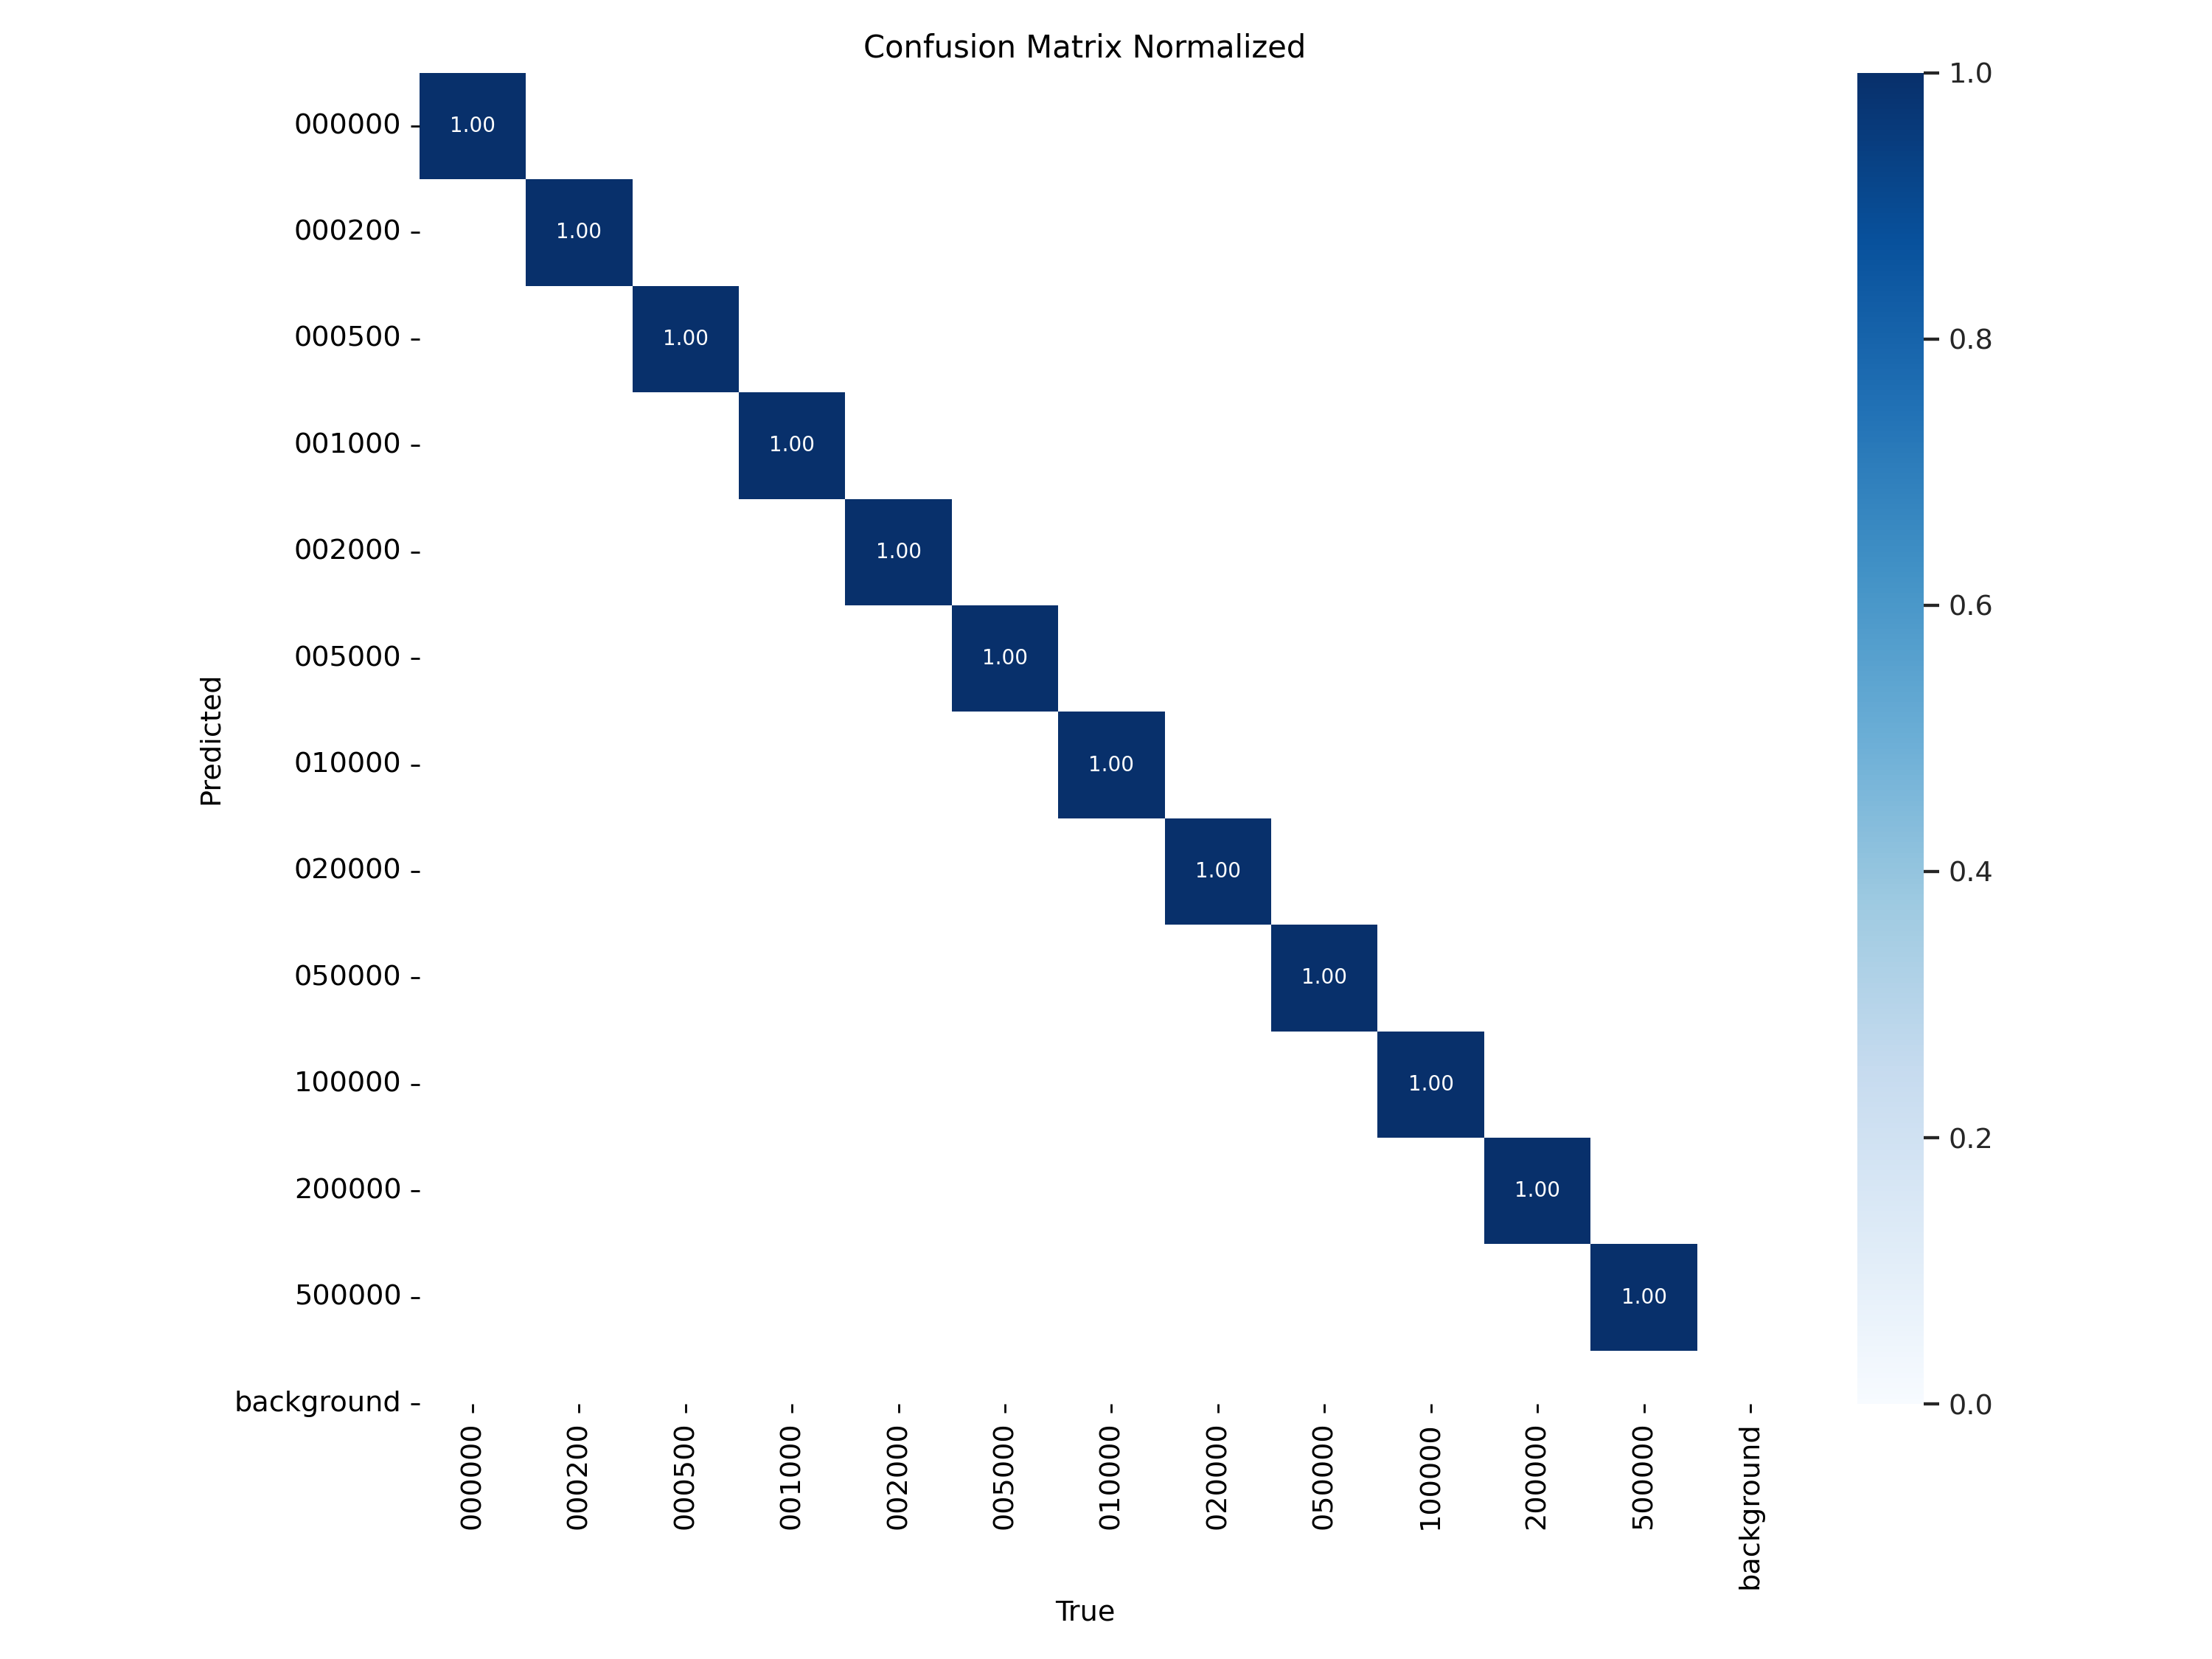

In [ ]:
Image(filename='/content/runs/classify/train/confusion_matrix_normalized.png')

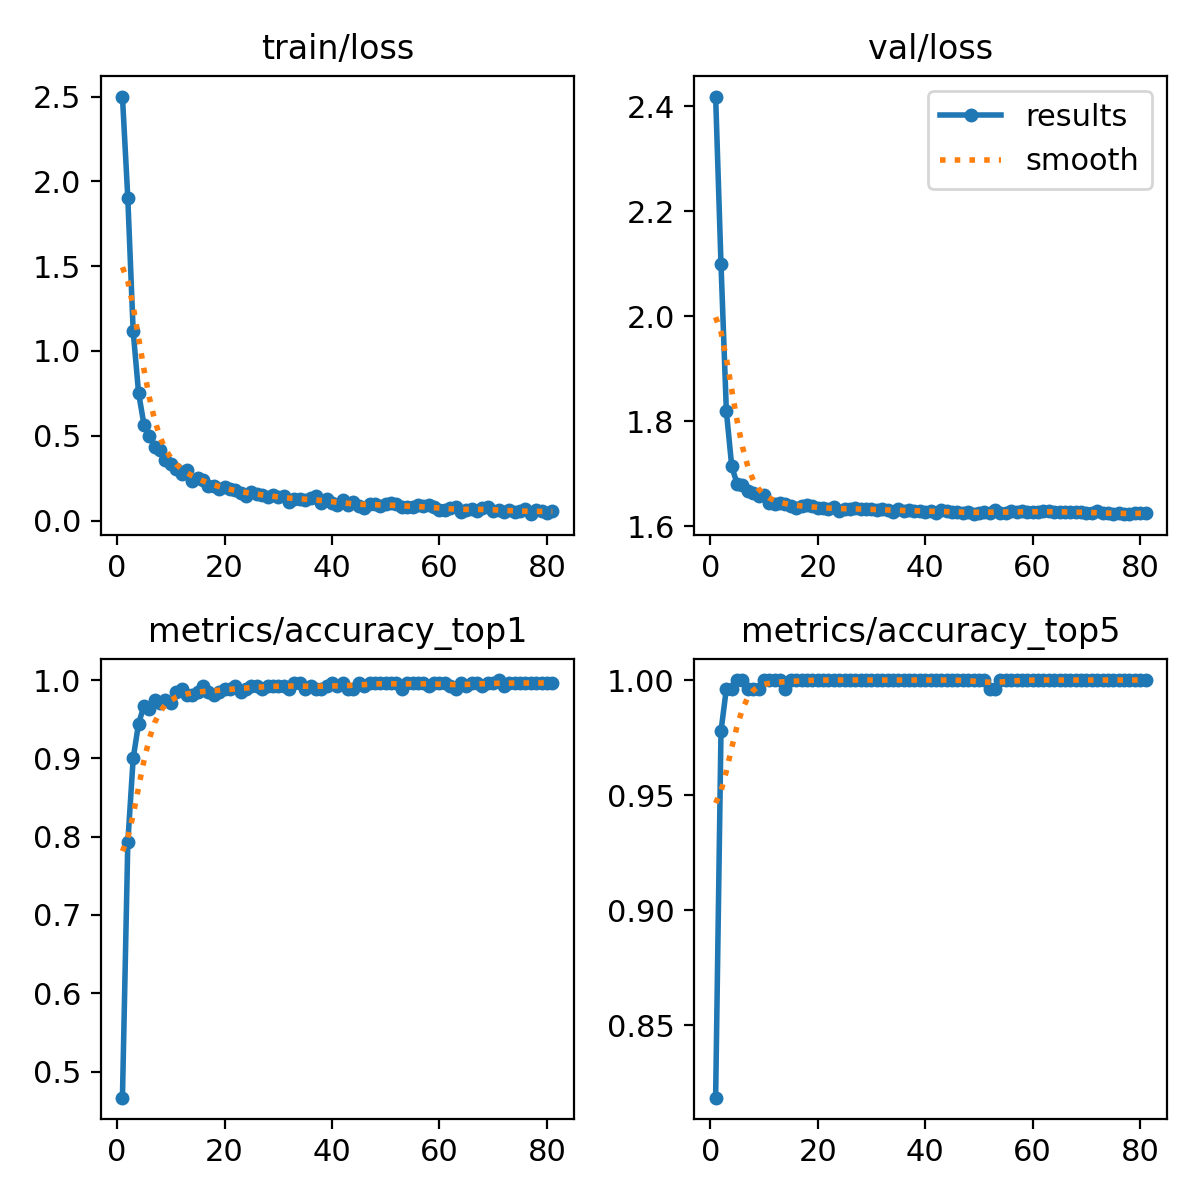

In [ ]:
Image(filename='/content/runs/classify/train/results.png')

# Saving the satisfy results in Google Drive

In [ ]:
!scp -r /content/runs '/content/drive/MyDrive/VN_Currency'

# Your own test images

In [ ]:
#Custom testing

pretrained_model = YOLO('/content/best.pt')

testing = pretrained_model(['/content/10kvnd.jpg', '/content/20kvnd.jpg', '/content/50kvnd.jpeg', '/content/010000_235.png'])

for test_res in testing:
  print(classes[test_res.probs.top1])